In [131]:
import matplotlib.pyplot as plt
import skimage.transform
import numpy as np
import math
import cv2


def display_masks(masks):
    """
    Display masks in a grid.
    Args:
        masks (list): A list of masks.
    """
    nrows = math.ceil(math.sqrt(len(masks)))
    ncols = math.ceil(math.sqrt(len(masks)))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 3))

    for i, ax in enumerate(axes.flat):
        # Check if we have enough masks to display
        if i < len(masks):
            # Resize the mask to 224 x 224
            resized_mask = skimage.transform.resize(
                masks[i].astype(np.uint8), (224, 224)
            )
            # Display the mask
            ax.imshow(resized_mask, cmap="gray")
            ax.set_title(f"mask of {i}")
        # Remove axis
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [132]:
from typing import List
from PIL import Image
import torch
from torchvision import transforms as T
from collections import namedtuple
import cv2
import numpy as np

InputItem = namedtuple("InputItem", ["image", "height", "width"])

def mask2contours(binary_mask, tolerance=1):
    contours = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    if tolerance <= 0:
        return contours
    else:
        return [cv2.approxPolyDP(cnt, tolerance, closed=True) for cnt in contours]


def mask2rotate_box(mask):
    coords = cv2.findNonZero(mask)
    (cx, cy), (w, h), angle = cv2.minAreaRect(coords)
    return cx, cy, w, h, angle


def mask2box(mask, format="xywh"):
    coords = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(coords)
    if format == "xywh":
        return [x, y, w, h]
    elif format == "xyxy":
        return [x, y, x + w, y + h]

def remove_mask_contains_relation(masks: torch.Tensor, scores: torch.Tensor, threshold: float = 0.5):
    N, H, W = masks.shape
    masks = masks.view(N, H * W).bool()
    indices = torch.tril_indices(N, N, -1)  # -1 excludes diagonal
    keep = torch.ones(N, dtype=torch.bool)

    for i, j in zip(indices[0], indices[1]):
        mask1 = masks[i]
        mask2 = masks[j]
        area1 = mask1.sum()
        area2 = mask2.sum()
        intersection = (mask1 & mask2).sum().float()

        if area1 > 0 and (intersection / area1 > threshold):
            keep[i] = False
        if area2 > 0 and (intersection / area2 > threshold):
            keep[j] = False

        # If both are marked to be removed, keep the one with the higher score
        if not keep[i] and not keep[j]:
            if scores[i] > scores[j]:
                keep[i] = True
            else:
                keep[j] = True

    return keep

def vectorized_remove_mask_contains_relation(masks: torch.Tensor, scores: torch.Tensor, threshold: float = 0.5):
    N, H, W = masks.shape
    masks = masks.view(N, H * W).bool()
    # Compute all intersections
    intersections = torch.matmul(masks.float(), masks.t().float())
    areas = intersections.diag()

    # Avoid division by zero and normalize intersection matrix by areas
    normalized_intersection = intersections / areas[:, None]

    # Apply threshold to identify masks with high overlap
    overlap = normalized_intersection > threshold

    # Ensure diagonal is false to not self-remove
    overlap.fill_diagonal_(False)

    # Determine which masks to keep (no high overlap with higher scored mask)
    scores_expanded = scores[:, None]
    dominated = (overlap & (scores_expanded <= scores_expanded.T)).any(dim=1)
    keep = ~dominated

    return keep


def apply_clahe(image, v=2, k=8):
    h, w = image.size
    image = np.uint8(image)

    clahe = cv2.createCLAHE(v, (max(2, int(h / k)), max(2, int(w / k))))
    img = Image.fromarray(
        np.stack(
            [
                clahe.apply(image[:, :, 0]),
                clahe.apply(image[:, :, 1]),
                clahe.apply(image[:, :, 2]),
            ],
            axis=-1,
        )
    )
    del clahe
    return img


class Predictor:

    image_process = T.Compose(
        [
             # T.Lambda(apply_clahe),
            T.Resize([1024, 1024]),
            T.ToTensor(),
            T.Lambda(lambda x: x * 255.0),
        ]
    )

    def __init__(
        self,
        ts_file,
        iou_threshold=0.7,
        score_threshold=0.5,
        device="cuda",
    ) -> None:
        self.ts_file = ts_file
        self.iou_threshold = iou_threshold
        self.score_threshold = score_threshold
        self.device = device
        # setup model
        self.model = torch.jit.freeze(torch.jit.load(self.ts_file, map_location=self.device))



    def preprocess(self, inputs: List[Image.Image]):
        processed_inputs = []
        for input_image in inputs:
            image_tensor = self.image_process(input_image)
            processed_inputs.append(
                InputItem(
                    image=image_tensor,
                    height=input_image.height,
                    width=input_image.width,
                )
            )
        return processed_inputs

    def inference(self, batch_inputs: List[InputItem]):
        with torch.no_grad():
            return self.model(batch_inputs)

    def predict(self, images):
        batched_inputs = self.preprocess(images)
        pred_results = self.inference(batched_inputs)
        return self.postprocessing(pred_results)

    def postprocessing(self, pred_outputs):
        final_results = []
        for pred_result in pred_outputs:
            pred_masks = pred_result[
                "pred_masks"
            ]  # .to(dtype=torch.bool) # .cpu().numpy().astype('uint8')
            pred_scores = pred_result["scores"]  # .cpu().numpy()

            # filter by score threshold
            pred_masks = pred_masks[pred_scores > self.score_threshold]
            pred_scores = pred_scores[pred_scores > self.score_threshold]

            keep = remove_mask_contains_relation(
                pred_masks, pred_scores, self.iou_threshold
            )
            pred_masks = pred_masks[keep].cpu().numpy().astype("bool")
            pred_scores = pred_scores[keep].cpu().numpy()

            final_results.append(dict(masks=pred_masks, scores=pred_scores))

            # return contours with scores
            # results = []
            # for mask, score in zip(pred_masks, scores):
            #     contours = mask2contours(mask)
            #     for cnt in contours:
            #         results.append({"cnt": cnt, "score": score})
            # final_results.append(results)
        del pred_outputs
        return final_results

In [133]:
from typing import Literal
import colorsys
import math
import numpy as np
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mc
from matplotlib.patches import Polygon, Rectangle
from matplotlib.lines import Line2D

__SMALL_OBJECT_AREA_THRESH__ = 1000


def mask_area(mask):
    """
    Args:
        mask (ndarray): a binary mask of shape (H, W).
    Returns:
        the area of the mask.
    """
    return mask.astype("bool").sum()


def mask2contour(binary_mask):
    contours = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contour = max(contours, key=cv2.contourArea)
    return contour


def mask2box(mask, format="xywh"):
    cnt = mask2contour(mask)
    x, y, w, h = cv2.boundingRect(cnt)
    if format == "xywh":
        return [x, y, w, h]
    elif format == "xyxy":
        return [x, y, x + w, y + h]


def mask2contours(binary_mask):
    binary_mask = np.uint8(binary_mask)
    contours = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    return contours


def mask2polygons(binary_mask):
    # cv2.RETR_CCOMP flag retrieves all the contours and arranges them to a 2-level
    # hierarchy. External contours (boundary) of the object are placed in hierarchy-1.
    # Internal contours (holes) are placed in hierarchy-2.
    # cv2.CHAIN_APPROX_NONE flag gets vertices of polygons from contours.
    mask = np.ascontiguousarray(
        binary_mask
    )  # some versions of cv2 does not support incontiguous arr
    res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    hierarchy = res[-1]
    if hierarchy is None:  # empty mask
        return [], False
    has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
    res = res[-2]
    res = [x.flatten() for x in res]
    # These coordinates from OpenCV are integers in range [0, W-1 or H-1].
    # We add 0.5 to turn them into real-value coordinate space. A better solution
    # would be to first +0.5 and then dilate the returned polygon by 0.5.
    res = [x + 0.5 for x in res if len(x) >= 6]
    return res, has_holes


def change_color_brightness(color, brightness_factor):
    """
    Depending on the brightness_factor, gives a lighter or darker color i.e. a color with
    less or more saturation than the original color.

    Args:
        color: color of the polygon. Refer to `matplotlib.colors` for a full list of
            formats that are accepted.
        brightness_factor (float): a value in [-1.0, 1.0] range. A lightness factor of
            0 will correspond to no change, a factor in [-1.0, 0) range will result in
            a darker color and a factor in (0, 1.0] range will result in a lighter color.

    Returns:
        modified_color (tuple[double]): a tuple containing the RGB values of the
            modified color. Each value in the tuple is in the [0.0, 1.0] range.
    """
    assert brightness_factor >= -1.0 and brightness_factor <= 1.0
    color = mc.to_rgb(color)
    polygon_color = colorsys.rgb_to_hls(*mc.to_rgb(color))
    modified_lightness = polygon_color[1] + (brightness_factor * polygon_color[1])
    modified_lightness = 0.0 if modified_lightness < 0.0 else modified_lightness
    modified_lightness = 1.0 if modified_lightness > 1.0 else modified_lightness
    modified_color = colorsys.hls_to_rgb(
        polygon_color[0], modified_lightness, polygon_color[2]
    )
    return tuple(np.clip(modified_color, 0.0, 1.0))


class Visualizer:
    def __init__(self, image, scale=1.0, cmap=None):
        self.original_image = image
        self.scale = scale
        self.fig = plt.figure(frameon=None)
        self.dpi = self.fig.get_dpi()
        self.height, self.width = image.shape[0], image.shape[1]
        self._default_font_size = max(
            np.sqrt(self.height * self.width) // 90, 10 // scale
        )
        self.fig.set_size_inches(
            (self.height * self.scale + 1e-2) / self.dpi,
            (self.width * self.scale + 1e-2) / self.dpi,
        )
        self.canvas = FigureCanvasAgg(self.fig)
        self.ax = self.fig.add_axes([0, 0, 1, 1])
        self.ax.axis("off")
        self.reset_image()
        self.cmap = (
            cmap
            if cmap is not None
            else (
                "#a6cee3",
                "#1f78b4",
                "#b2df8a",
                "#33a02c",
                "#fb9a99",
                "#e31a1c",
                "#fdbf6f",
                "#ff7f00",
                "#cab2d6",
                "#6a3d9a",
                "#ffff99",
                "#b15928",
                "#8dd3c7",
                "#333333",
                "#bebada",
                "#fb8072",
                "#80b1d3",
                "#fdb462",
                "#b3de69",
                "#fccde5",
                "#d9d9d9",
                "#bc80bd",
                "#ccebc5",
                "#ffed6f",
            )
        )

    def get_output(self):
        """
        Returns:
            ndarray:
                the visualized image of shape (H, W, 3) (RGB) in uint8 type.
                The shape is scaled w.r.t the input image using the given `scale` argument.
        """
        canvas = self.canvas
        s, (width, height) = canvas.print_to_buffer()
        # buf = io.BytesIO()  # works for cairo backend
        # canvas.print_rgba(buf)
        # width, height = self.width, self.height
        # s = buf.getvalue()

        buffer = np.frombuffer(s, dtype="uint8")

        img_rgba = buffer.reshape(height, width, 4)
        rgb, alpha = np.split(img_rgba, [3], axis=2)
        return rgb.astype("uint8")

    def reset_image(self):
        self.ax.imshow(
            self.original_image,
            extent=(0, self.width, self.height, 0),
            interpolation="nearest",
        )

    def draw_polygon(self, polygon, color, edge_color, alpha=0.5):
        if edge_color is None:
            # make edge color darker than the polygon color
            if alpha > 0.8:
                edge_color = change_color_brightness(color, brightness_factor=-0.7)
            else:
                edge_color = color
        edge_color = mc.to_rgb(edge_color) + (1,)
        self.ax.add_patch(
            Polygon(
                polygon,
                # fill=True,
                fill=False,
                facecolor=mc.to_rgb(color) + (alpha,),
                edgecolor=edge_color,
                linewidth=0.1
            )
        )
        return self

    def draw_masks(self, masks):
        for i, mask in enumerate(masks):
            color = self.cmap[i % len(self.cmap)]
            polygons = mask2contour(mask)
            self.draw_polygon(polygons.reshape(-1, 2), color, color)
        return self

    def draw_box_xyxy(self, bbox, edge_color, line_style="-", alpha=0.5):
        x1, y1, x2, y2 = bbox
        self.ax.add_patch(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                edgecolor=edge_color,
                linewidth=2,
                linestyle=line_style,
                alpha=alpha,
            )
        )
        return self

    def draw_box_xywh(self, bbox, edge_color, line_style="-", alpha=0.5):
        x, y, w, h = bbox
        self.ax.add_patch(
            Rectangle(
                (x, y),
                w,
                h,
                fill=False,
                edgecolor=edge_color,
                linewidth=2,
                linestyle=line_style,
                alpha=alpha,
            )
        )
        return self

    def draw_text(
        self,
        text,
        position,
        *,
        font_size=None,
        font_color="g",
        horizontal_alignment="center",
        rotation=0,
        **kwargs,
    ):
        if not font_size:
            font_size = self._default_font_size

        # since the text background is dark, we don't want the text to be dark
        color = np.maximum(list(mc.to_rgb(font_color)), 0.2)
        color[np.argmax(color)] = max(0.8, np.max(color))

        x, y = position
        self.ax.text(
            x,
            y,
            text,
            size=font_size * self.scale,
            family="sans-serif",
            color=color,
            horizontalalignment=horizontal_alignment,
            zorder=10,
            rotation=rotation,
            bbox={"facecolor": "black", "alpha": 0.5, "pad": 0.7, "linewidth": 0},
            **kwargs,
        )
        return self

    def draw_line(self, x_data, y_data, color, linestyle="-", linewidth=None):
        """
        Args:
            x_data (list[int]): a list containing x values of all the points being drawn.
                Length of list should match the length of y_data.
            y_data (list[int]): a list containing y values of all the points being drawn.
                Length of list should match the length of x_data.
            color: color of the line. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            linestyle: style of the line. Refer to `matplotlib.lines.Line2D`
                for a full list of formats that are accepted.
            linewidth (float or None): width of the line. When it's None,
                a default value will be computed and used.

        Returns:
            output (VisImage): image object with line drawn.
        """
        if linewidth is None:
            linewidth = self._default_font_size / 3
        # linewidth = max(linewidth, 1)
        linewidth = 0.3
        self.ax.add_line(
            Line2D(
                x_data,
                y_data,
                linewidth=linewidth * self.scale,
                color=color,
                linestyle=linestyle,
            )
        )
        return self

    def draw_rotated_box_with_label(
        self, rotated_box, alpha=0.5, edge_color="g", line_style="-", label=None
    ):
        """
        Draw a rotated box with label on its top-left corner.

        Args:
            rotated_box (tuple): a tuple containing (cnt_x, cnt_y, w, h, angle),
                where cnt_x and cnt_y are the center coordinates of the box.
                w and h are the width and height of the box. angle represents how
                many degrees the box is rotated CCW with regard to the 0-degree box.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            edge_color: color of the outline of the box. Refer to `matplotlib.colors`
                for full list of formats that are accepted.
            line_style (string): the string to use to create the outline of the boxes.
            label (string): label for rotated box. It will not be rendered when set to None.

        Returns:
            output (VisImage): image object with box drawn.
        """
        cnt_x, cnt_y, w, h, angle = rotated_box
        area = w * h
        # use thinner lines when the box is small
        linewidth = self._default_font_size / (
            6 if area < __SMALL_OBJECT_AREA_THRESH__ * self.scale else 3
        )

        theta = angle * math.pi / 180.0
        c = math.cos(theta)
        s = math.sin(theta)
        rect = [(-w / 2, h / 2), (-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2)]
        # x: left->right ; y: top->down
        rotated_rect = [
            (cnt_x - xx * c + yy * s, cnt_y - xx * s - yy * c) for (xx, yy) in rect
        ]
        for k in range(4):
            j = (k + 1) % 4
            self.draw_line(
                [rotated_rect[k][0], rotated_rect[j][0]],
                [rotated_rect[k][1], rotated_rect[j][1]],
                color=edge_color,
                linestyle="--" if k == 1 else line_style,
                linewidth=linewidth,
            )

        if label is not None:
            text_pos = rotated_rect[1]  # topleft corner

            height_ratio = h / np.sqrt(self.height * self.width)
            label_color = self._change_color_brightness(
                edge_color, brightness_factor=0.7
            )
            font_size = (
                np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
                * 0.5
                * self._default_font_size
            )
            self.draw_text(
                label, text_pos, color=label_color, font_size=font_size, rotation=angle
            )

        return self

    def draw_box_roate(self, rotated_box, edge_color, line_style="-"):
        """
        Draw a rotated box with label on its top-left corner.

        Args:
            rotated_box (tuple): a tuple containing (cnt_x, cnt_y, w, h, angle),
                where cnt_x and cnt_y are the center coordinates of the box.
                w and h are the width and height of the box. angle represents how
                many degrees the box is rotated CCW with regard to the 0-degree box.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            edge_color: color of the outline of the box. Refer to `matplotlib.colors`
                for full list of formats that are accepted.
            line_style (string): the string to use to create the outline of the boxes.
            label (string): label for rotated box. It will not be rendered when set to None.

        Returns:
            output (VisImage): image object with box drawn.
        """
        # print(rotated_box)
        cnt_x, cnt_y, w, h, angle = rotated_box
        area = w * h
        # use thinner lines when the box is small
        linewidth = self._default_font_size / (
            20 if area < __SMALL_OBJECT_AREA_THRESH__ * self.scale else 10
        )

        theta = angle * math.pi / 180.0
        c = math.cos(theta)
        s = math.sin(theta)
        rect = [(-w / 2, h / 2), (-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2)]
        # x: left->right ; y: top->down
        # cw rotate
        rotated_rect = [
            (cnt_x - xx * c + yy * s, cnt_y - xx * s - yy * c) for (xx, yy) in rect
        ]
        for k in range(4):
            j = (k + 1) % 4
            self.draw_line(
                [rotated_rect[k][0], rotated_rect[j][0]],
                [rotated_rect[k][1], rotated_rect[j][1]],
                color=edge_color,
                linestyle=line_style,
                linewidth=linewidth,
            )
        return self

    def overlay_instances(
        self,
        *,
        labels=None,
        masks=None,
        boxes=None,
        scores=None,
        box_format: Literal["rotate", "xyxy", "xywh"] = "xyxy",
        label_mapping=lambda x: x,
        text_mapping=lambda label, score: f"{label if label else ''}{'_' if (label and score) else ''}{'%.2f' % score if score else ''}",
    ):
        num_instances = 0
        if boxes is not None:
            num_instances = len(boxes)
        if masks is not None:
            if num_instances:
                assert len(masks) == num_instances
            else:
                num_instances = len(masks)

        if labels is not None and scores is not None:
            assert len(labels) == num_instances and len(scores) == num_instances
        elif labels is not None and scores is None:
            scores = np.zeros_like(labels, dtype=np.bool8)
        elif labels is None and scores is not None:
            labels = np.zeros_like(scores, dtype=np.bool8)
        if num_instances == 0:
            return self
        areas = None
        if boxes is not None:
            if box_format == "rotate":
                areas = boxes[:, 2] * boxes[:, 3]
            else:
                areas = np.prod(boxes[:, 2:] - boxes[:, :2], axis=1)
        elif masks is not None:
            areas = np.asarray([mask_area(x) for x in masks])

        if areas is not None:
            sorted_idxs = np.argsort(-areas).tolist()
            # Re-order overlapped instances in descending order.
            boxes = boxes[sorted_idxs] if boxes is not None else None
            labels = [labels[k] for k in sorted_idxs] if labels is not None else None
            masks = [masks[idx] for idx in sorted_idxs] if masks is not None else None
            scores = scores[sorted_idxs] if scores is not None else None

        for i in range(num_instances):
            color = self.cmap[i % len(self.cmap)]

            # draw box
            if boxes is not None:
                if box_format == "xyxy":
                    self.draw_box_xyxy(
                        boxes[i], change_color_brightness(color, brightness_factor=-0.2)
                    )
                elif box_format == "xywh":
                    self.draw_box_xywh(
                        boxes[i], change_color_brightness(color, brightness_factor=-0.2)
                    )
                elif box_format == "rotate":
                    self.draw_box_roate(
                        boxes[i], change_color_brightness(color, brightness_factor=-0.2)
                    )
                else:
                    raise ValueError("Unknown box format: {}".format(box_format))

            # draw mask
            if masks is not None:
                polygons = mask2contours(masks[i])
                for polygon in polygons:
                    self.draw_polygon(
                        polygon.reshape(-1, 2),
                        color,
                        change_color_brightness(color, brightness_factor=-0.5),
                    )

            # draw text
            if labels is None or scores is None:
                continue
            else:
                if boxes is not None:
                    if box_format == "xywh":
                        _x, _y, _w, _h = boxes[i]
                        x1, y1, x2, y2 = _x, _y, _x + _w, _y + _h
                        text_pos = (x1, y1)
                        horizontal_align = "left"
                    elif box_format == "xyxy":
                        x1, y1, x2, y2 = boxes[i]
                        text_pos = (x1, y1)
                        horizontal_align = "left"
                    elif box_format == "rotate":
                        cx, cy, r_w, r_h, angle = boxes[i]
                        theta = angle * math.pi / 180.0
                        points = [(-r_w / 2, -r_h / 2), (r_w / 2, r_h / 2)]
                        (x1, y1), (x2, y2) = [
                            (
                                cx - xx * math.cos(theta) + yy * math.sin(theta),
                                cy - xx * math.sin(theta) - yy * math.cos(theta),
                            )
                            for (xx, yy) in points
                        ]
                        text_pos = (x1, y1)
                        horizontal_align = "left"
                    else:
                        raise ValueError("Unknown box format: {}".format(box_format))

                elif masks is not None:
                    text_pos = np.median(masks[i].nonzero(), axis=1)[::-1]
                    x1, y1, x2, y2 = mask2box(masks[i], format="xyxy")
                    horizontal_align = "center"

                else:
                    continue

                if box_format == "rotate":
                    text_pos = (x1, y1)
                    height_ratio = r_h / np.sqrt(self.height * self.width)
                    font_size = (
                        np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
                        * 0.5
                        * self._default_font_size
                    )
                else:
                    instance_area = (x2 - x1) * (y2 - y1)
                    if (
                        instance_area < __SMALL_OBJECT_AREA_THRESH__ * self.scale
                        or y2 - y1 < 40 * self.scale
                    ):
                        if y1 > self.height - 5:
                            text_pos = (x2, y1)
                        else:
                            text_pos = (x1, y2)

                    height_ratio = (y2 - y1) / np.sqrt(self.height * self.width)

                    font_size = (
                        np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
                        * 0.5
                        * self._default_font_size
                    )
                self.draw_text(
                    text_mapping(label_mapping(labels[i]), scores[i]),
                    text_pos,
                    font_size=font_size,
                    font_color=change_color_brightness(color, brightness_factor=0.5),
                    horizontal_alignment=horizontal_align,
                )
        return self


In [134]:
# predictor = Predictor(r"./model/20240223-mask2former-sam_h.pt",iou_threshold=0.7,score_threshold=0.5, device="cpu")
predictor = Predictor(r"./model/20240223-mask2former-sam_h.pt",iou_threshold=0.7,score_threshold=0.5)

In [135]:
test_image_path = r"./test/L2406270005.001.mid.png"

In [136]:
outputs = predictor.predict([
    Image.open(test_image_path).convert("RGB")
])

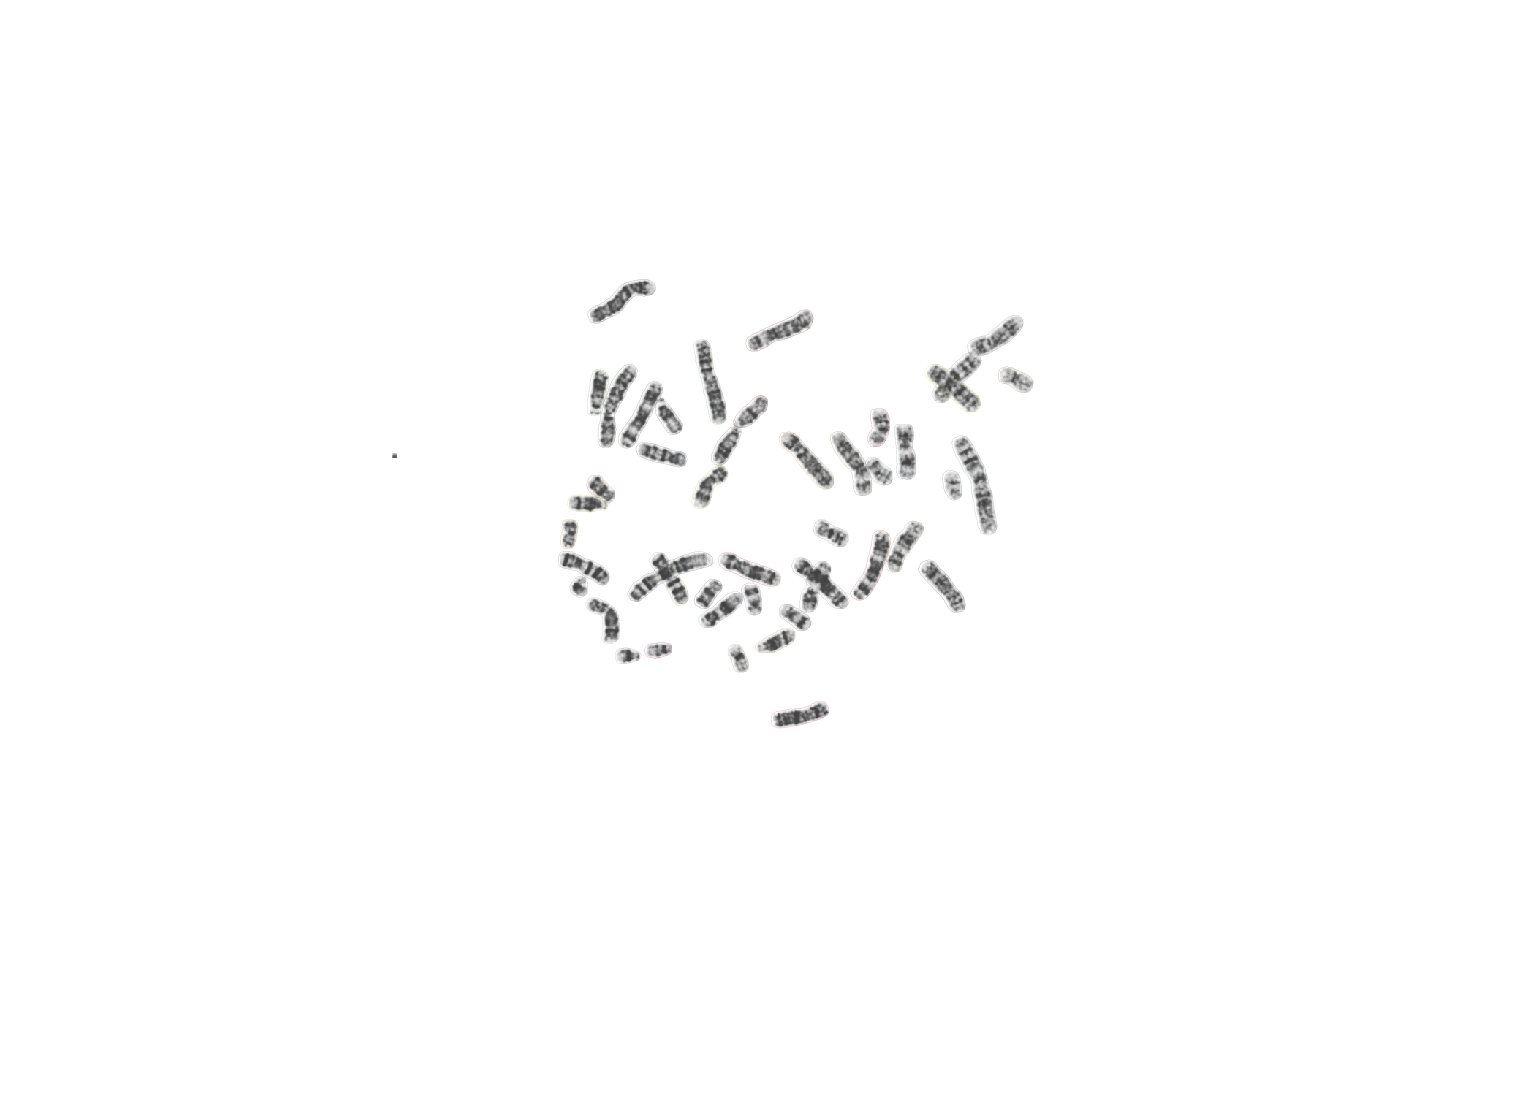

In [137]:
result = outputs[0]
pred_masks =  result['masks']
Visualizer(np.asanyarray(Image.open(test_image_path).convert('RGB'))).overlay_instances(
    masks=np.uint8(pred_masks),
    # boxes=np.asarray([mask2box(m,format='xyxy') for m in np.uint8(pred_masks)],dtype='int32')
)

In [138]:
# 将结果中的mask再罩回到原图上，再求一次更精确的轮廓，然后再画到原图上
from utils.chromo_cv_utils import cv_imread

src_img = cv_imread(test_image_path)
canvas = cv_imread(test_image_path)
for mask in pred_masks:
    mask = mask.astype(np.uint8)
    # 将mask罩回原图，取出单根染色体
    masked_img = cv2.bitwise_and(src_img, src_img, mask=mask)
    # 对masked_img进行二值化
    gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY) if len(masked_img.shape) == 3 else masked_img
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # 求轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    assert len(contours) == 1
    contour = contours[0]
    # 画轮廓
    cv2.drawContours(canvas, [contour], -1, (0, 255, 0), 1)

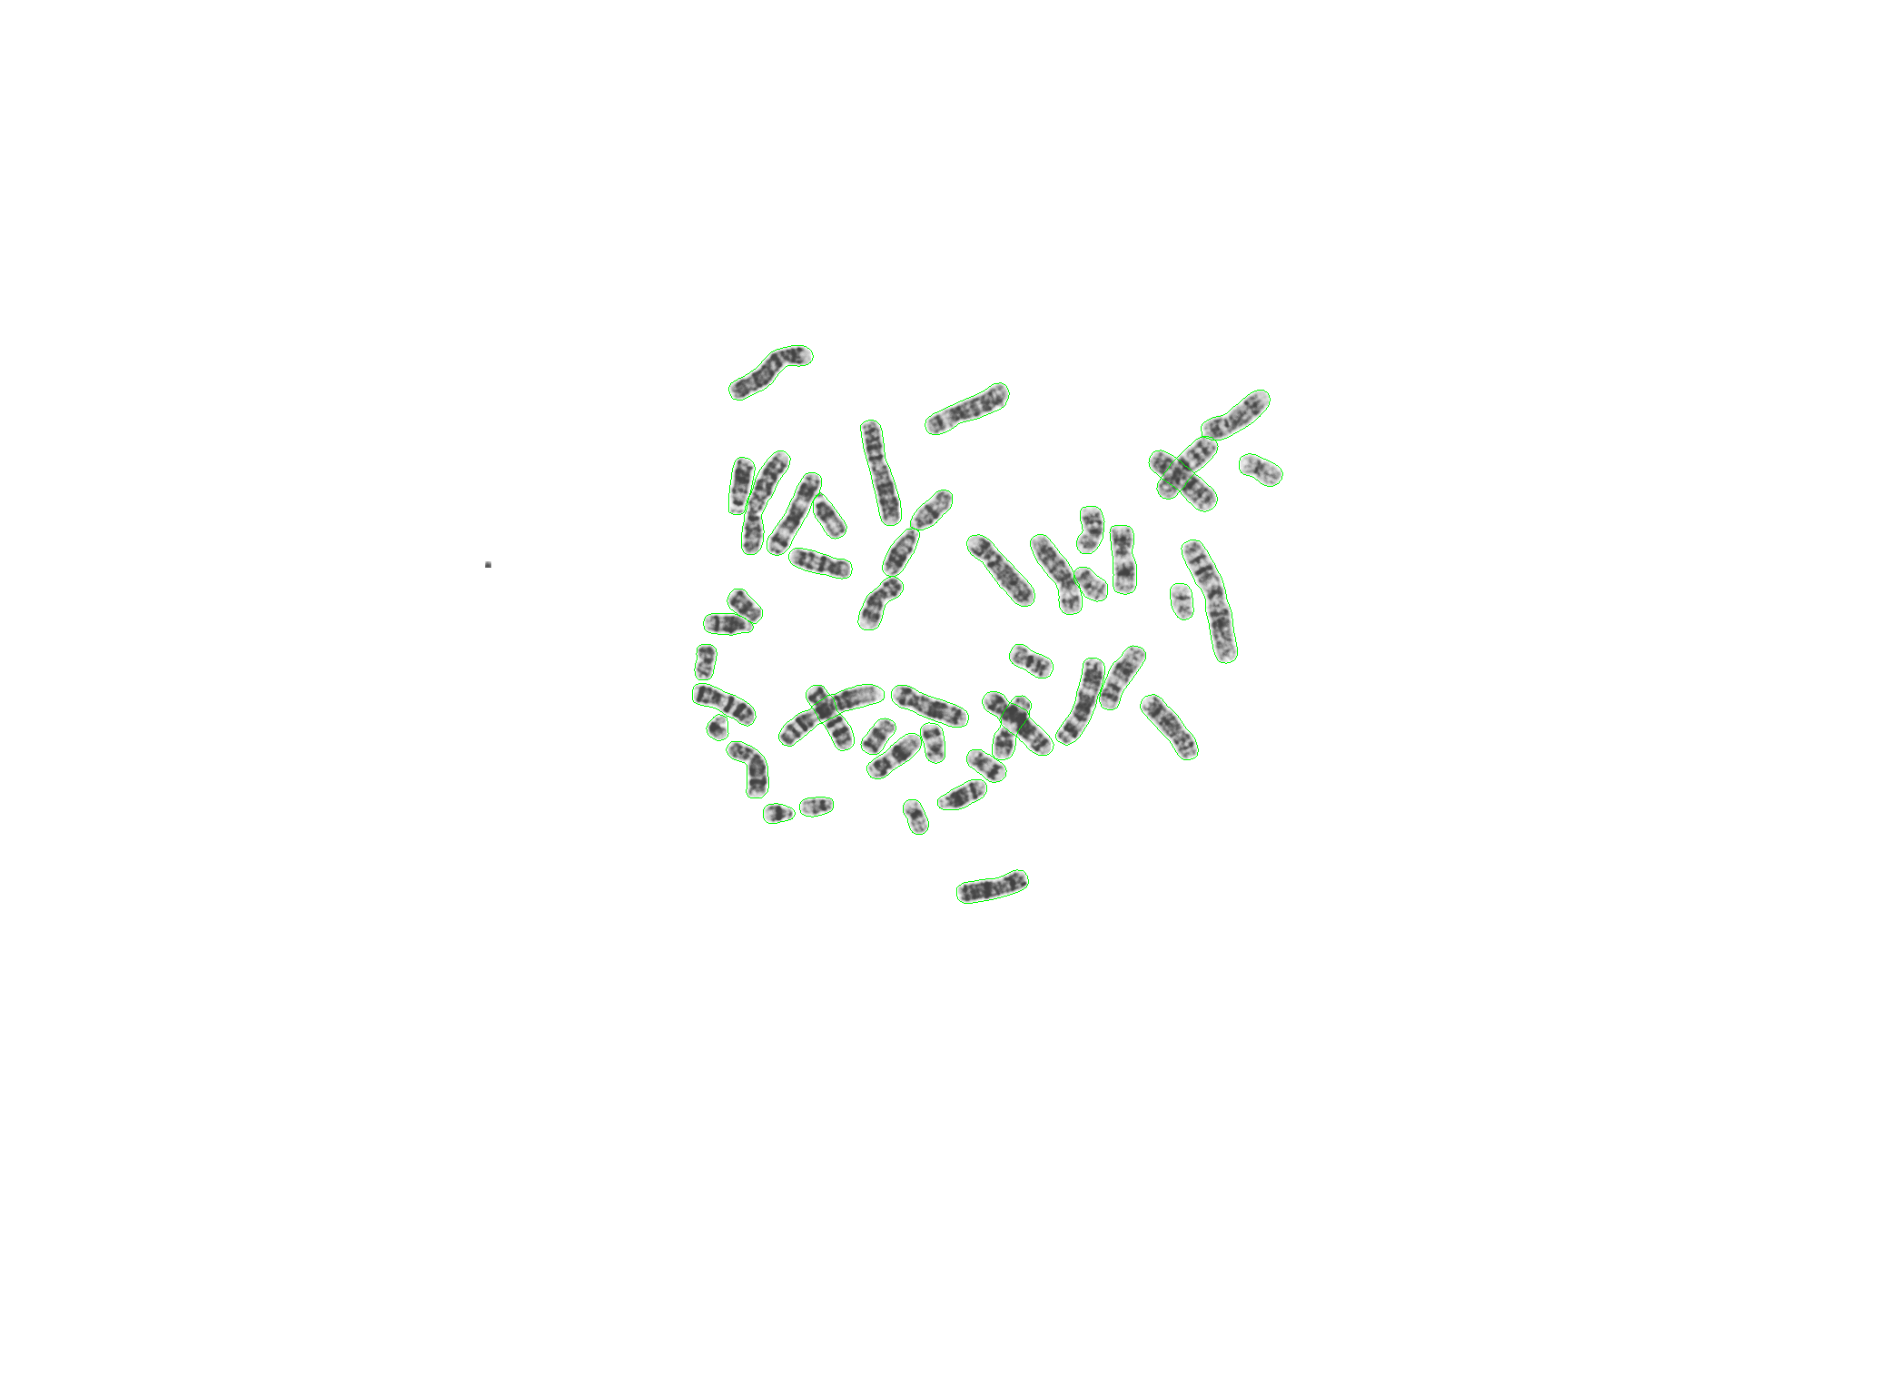

In [139]:
# 显示canvas
plt.figure(figsize=(24, 18))  # 设置为自己需要的大小
# plt.imshow(canvas, aspect='auto')  # 或者指定其他的比例，如'equal'
plt.imshow(canvas)
plt.axis('off')  # 可选：关闭坐标轴显示
plt.show()
# plt.savefig('canvas_highres.png', dpi=300)  # 保存为300 DPI的高分辨率图像

In [140]:
from utils.chromo_cv_utils import cv_imwrite

cv_imwrite(r"./test/分割染色体的效果对比-中期图-重新求轮廓后-1号线.png", canvas)

In [141]:
# display_masks(result['masks'])

## 解析报告图

In [142]:
def contour_bbox_img(img, contour):
    """
    Get the bounding box img of a contour.

    Args:
        img: Image.
        contour: Contour.

    Returns:
        cropped: Bounding box image, with grayscale and black background.
        target_on_white: Bounding box image, with white background, not grayscale.
    """
    # if not grayscale, convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img

    # Create a mask for the contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Extract the target
    extracted = cv2.bitwise_and(gray, gray, mask=mask)

    # get bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the object with some padding, adjust padding as needed
    padding = 1
    cropped = extracted[y - padding : y + h + padding, x - padding : x + w + padding]

    # make it white background
    wbg_cropped = np.full_like(cropped, 255, dtype=np.uint8)
    np.copyto(wbg_cropped, cropped, where=(cropped > 0))

    return cropped, wbg_cropped

In [143]:
from karyotype import Karyotype

# 对报告图进行解析
kyt_chart = Karyotype(r"./test/L2402051562.003.K.JPG")
chromo_dicts_orgby_cy = kyt_chart.read_karyotype()

# 简化染色体字典，并添加单根染色体的白色背景和黑色背景bbox图片
kyt_chromos = []
for chromo_dicts in chromo_dicts_orgby_cy.values():
    # 同编号的染色体按cx坐标排序
    chromo_dicts.sort(key=lambda x: x["cx"])
    same_chromo_idx = 0
    pre_chromo_id = chromo_dicts[0]["chromo_id"]
    for i, chromo_dict in enumerate(chromo_dicts):
        chromo_bbox_bbg, chromo_bbox_wbg = contour_bbox_img(kyt_chart.img["img"], chromo_dict["cntr"])
        chromo_dict["bbox_bbg"] = chromo_bbox_bbg
        chromo_dict["bbox_wbg"] = chromo_bbox_wbg

        cur_chromo_id = chromo_dict["chromo_id"]
        if pre_chromo_id == cur_chromo_id:
            chromo_dict["pos"] = same_chromo_idx
            same_chromo_idx += 1
        else:
            same_chromo_idx = 0
            chromo_dict["pos"] = same_chromo_idx
        pre_chromo_id = cur_chromo_id

        kyt_chromos.append(chromo_dict)

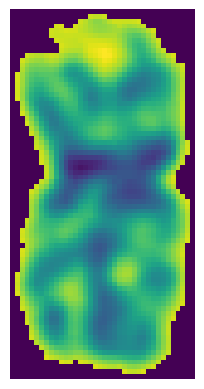

In [144]:
# check results
# plt.figure(figsize=(24, 18))  # 设置为自己需要的大小
# plt.imshow(canvas, aspect='auto')  # 或者指定其他的比例，如'equal'
plt.imshow(kyt_chromos[0]["bbox_bbg"])
plt.axis('off')  # 可选：关闭坐标轴显示
plt.show()
# plt.savefig('canvas_highres.png', dpi=300)  # 保存为300 DPI的高分辨率图像

In [145]:
def feature_match_on_roi_for_flips(query_roi, target_roi):
    """通过SIFT特征匹配算法,并使用不同的翻转(flip)方式(上下翻转0, 左右翻转1, 上下左右-1),
    来计算两个ROI的相似度,
    并返回最佳的flip方式, 相似度和最佳匹配时两个图像是否颠倒

    Args:
        query_roi (_type_): Region of interest 1.
        target_roi (_type_): Region of interest 2.

    Returns:
        similarity (float): similarity score in %
        flip_idx (int): 最佳的flip方式
        upside_down (bool): 最佳匹配时两个图像是否颠倒
    """
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    # Initialize BFMatcher
    bf = cv2.BFMatcher()
    # Detect keypoints and compute descriptors for target ROI
    target_kpts, target_descs = sift.detectAndCompute(target_roi, None)

    # 4个翻转方式 [不翻转, 上下翻转, 左右翻转, 上下左右翻转]
    query_flip_rois = [
        query_roi,
        cv2.flip(query_roi, 0),
        cv2.flip(query_roi, 1),
        cv2.flip(query_roi, -1),
    ]
    matches_list = []
    max_sim_flip_idx = 0
    max_sim = 0
    for flip_idx, roi in enumerate(query_flip_rois):
        # Detect keypoints and compute descriptors for query ROI
        query_kpts, query_descs = sift.detectAndCompute(roi, None)
        # Match descriptors between ROIs
        matches = bf.knnMatch(query_descs, target_descs, k=2)
        good_matches = [[m] for m, n in matches if m.distance < 0.75 * n.distance]
        similarity = (
            len(good_matches) / max(len(query_kpts), len(target_kpts)) * 100
            if max(len(query_kpts), len(target_kpts)) > 0
            else 0
        )
        matches_list.append(
            {
                "flip_idx": flip_idx, # 4个翻转方式的索引 [0.不翻转(None), 1.上下翻转(0), 2.左右翻转(1), 3.上下左右翻转(-1)]
                "similarity": similarity, # 相似度%
                "good_matches": good_matches, # 好的匹配的特征点
                "query_kpts": query_kpts, # 查询ROI的关键点
                "query_descs": query_descs, # 查询ROI的描述符
                "target_kpts": target_kpts, # 目标ROI的关键点
                "target_descs": target_descs, # 目标ROI的描述符
            }
        )
        if similarity > max_sim:
            max_sim = similarity
            max_sim_flip_idx = flip_idx

    best_flip = matches_list[max_sim_flip_idx]
    flip_idx_in_best = best_flip["flip_idx"]
    good_matches_on_best = best_flip["good_matches"]
    if len(good_matches_on_best) > 5:
        # 判断最佳匹配时两个图像是否相互颠倒
        # get matched points
        matched_pts = []
        for match in good_matches_on_best:
            query_idx = match[0].queryIdx
            train_idx = match[0].trainIdx
            query_kpt = best_flip["query_kpts"][query_idx]
            target_kpt = best_flip["target_kpts"][train_idx]
            # get matched points
            query_pt = query_kpt.pt
            target_pt = target_kpt.pt
            matched_pts.append((query_pt, target_pt))
        # 在query_roi中位于图像上半部分的匹配点,在target_roi上对应的匹配点有半数以上都位下半部分;
        # 并且，在query_roi中位于图像下半部分的匹配点,在target_roi上对应的匹配点有半数以上都位上半部分;
        # 则，说明两个图像是相互颠倒的
        pts_amt = len(good_matches_on_best)
        # print(f"pts_amt: {pts_amt}")
        # 求在query_roi中位于图像上半部分的匹配点,在target_roi上对应的匹配点位下半部分的点的个数
        query_roi_height_half = query_roi.shape[0] / 2
        target_roi_height_half = target_roi.shape[0] / 2
        mutually_upside_down_pts_amt = 0
        for matched_pt in matched_pts:
            query_pt, target_pt = matched_pt
            if query_pt[1] < query_roi_height_half and target_pt[1] > target_roi_height_half:
                mutually_upside_down_pts_amt += 1
            elif query_pt[1] > query_roi_height_half and target_pt[1] < target_roi_height_half:
                mutually_upside_down_pts_amt += 1
            else:
                continue
        mutually_upside_down = mutually_upside_down_pts_amt / pts_amt > 0.5
        upside_down = mutually_upside_down if max_sim_flip_idx in [0, 2] else not mutually_upside_down
    else:
        upside_down = False
    '''best_flip = {
        "flip_idx": flip_idx,
        "similarity": similarity,
        "good_matches": good_matches,
        "query_kpts": query_kpts,
        "query_descs": query_descs,
        "target_kpts": target_kpts,
        "target_descs": target_descs,
    }
    '''
    return max_sim, flip_idx_in_best, upside_down, best_flip # 最高相似度，最佳匹配下的翻转方式索引，是否颠倒，最佳匹配下的详细信息


def best_feature_match_for_chromos(query_chromo, target_chromos):
    """利用特征点匹配算法计算染色体图像的相似度

    Args:
        query_chromo (numpy ndarray): 查询染色体图像
        target_chromos (list of numpy ndarray): 目标染色体图像列表

    Returns:
        最佳特征点匹配相似度, 最佳匹配的目标染色体
    """
    sim_score_max = 0
    target_chromo_on_max = None
    target_chromo_flip_idx_on_max = 0
    target_chromo_upside_down_on_max = False
    target_chromo_flip_on_max = None
    for target_chromo in target_chromos:
        try:
            sim_score, flip_idx, upside_down, best_flip = feature_match_on_roi_for_flips(
                query_chromo["bbox_bbg"], target_chromo["bbox_bbg"]
            )
        except Exception as e:  # pylint: disable=broad-except
            print(e)
            continue
        if sim_score > sim_score_max:
            sim_score_max = sim_score
            target_chromo_on_max = target_chromo
            target_chromo_flip_idx_on_max = flip_idx
            target_chromo_upside_down_on_max = upside_down
            target_chromo_flip_on_max = best_flip

    '''target_chromo_flip_on_max = {
        "flip_idx": flip_idx,
        "similarity": similarity,
        "good_matches": good_matches,
        "query_kpts": query_kpts,
        "query_descs": query_descs,
        "target_kpts": target_kpts,
        "target_descs": target_descs,
    }
    '''
    return (
        sim_score_max,
        target_chromo_on_max,
        target_chromo_flip_idx_on_max,
        target_chromo_upside_down_on_max,
        target_chromo_flip_on_max
    )


In [146]:
# from utils.chromo_cv_utils import best_feature_match_for_chromos

# 将模型分割输出的掩码将原图中的染色体提取出来，形成同样尺寸黑背景的图片
metaphase_chromos = []
for mask in pred_masks:
    mask = mask.astype(np.uint8)
    # 将mask罩回原图，取出单根染色体
    masked_img = cv2.bitwise_and(src_img, src_img, mask=mask)
    chromo_dict = {
        "bbox_bbg": masked_img,
    }
    metaphase_chromos.append(chromo_dict)

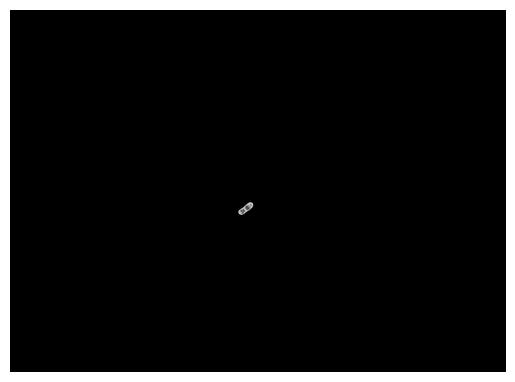

In [147]:
# check results
# plt.figure(figsize=(24, 18))  # 设置为自己需要的大小
# plt.imshow(canvas, aspect='auto')  # 或者指定其他的比例，如'equal'
plt.imshow(metaphase_chromos[0]["bbox_bbg"])
plt.axis('off')  # 可选：关闭坐标轴显示
plt.show()
# plt.savefig('canvas_highres.png', dpi=300)  # 保存为300 DPI的高分辨率图像lkfds

In [148]:
sim_score, flip_idx, upside_down, best_flip = feature_match_on_roi_for_flips(kyt_chromos[0]['bbox_bbg'], metaphase_chromos[0]["bbox_bbg"])
# 绘制匹配的特征点
flip_param = [None, 0, 1, -1]
metaphase_chromo_kps = best_flip["target_kpts"]
kyt_chromo_kps = best_flip["query_kpts"]
kyt_flip_idx = best_flip["flip_idx"]
img_matches = cv2.drawMatchesKnn(kyt_chromos[0]['bbox_bbg'], metaphase_chromo_kps, metaphase_chromos[0]["bbox_bbg"], kyt_chromo_kps, best_flip["good_matches"], None, flags=2)

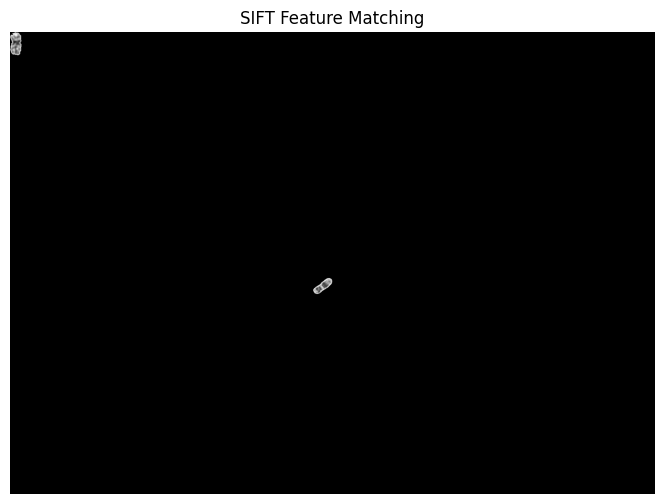

In [149]:
# 显示结果
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.title('SIFT Feature Matching')
plt.axis('off')
plt.show()

In [150]:
# 用报告图中的染色体去匹配分割出来的染色体，求得匹配度最高的染色体
matched_chromos = []
for kyt_chromo in kyt_chromos:
    sim_score, metaphase_chromo, flip_idx, upsidedown, best_match_dict = best_feature_match_for_chromos(kyt_chromo, metaphase_chromos)
    matched_chromos.append({
        "kyt_chromo": kyt_chromo,
        "sim_score": sim_score,
        "metaphase_chromo": metaphase_chromo,
        "flip_idx": flip_idx,
        "upsidedown": upsidedown,
        "best_match_dict": best_match_dict
    })

len(matched_chromos)

40

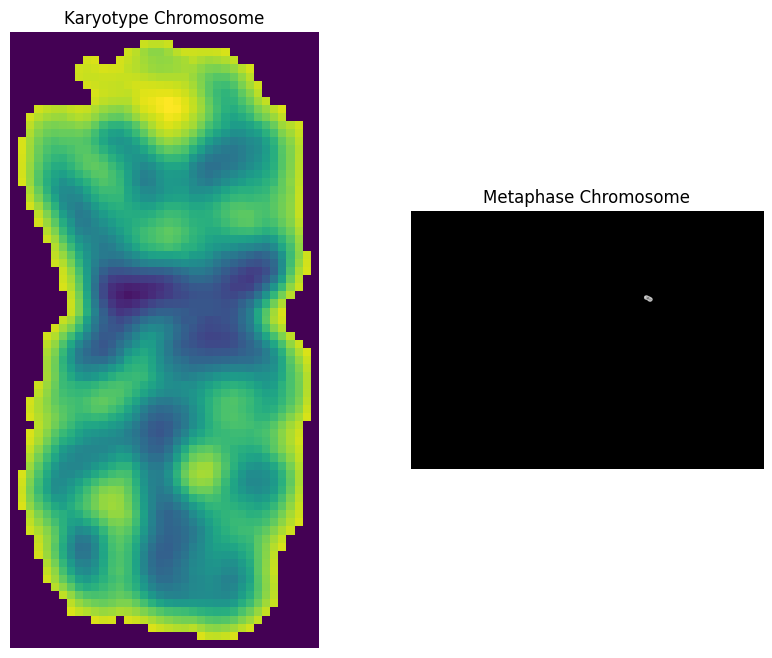

In [151]:
# check result
# metaphase_chromos[1]

fig, axes = plt.subplots(1, 2, figsize=(10, 8))  # 创建1行2列的子图
axes[0].imshow(matched_chromos[0]['kyt_chromo']['bbox_bbg'])
axes[0].set_title('Karyotype Chromosome')
axes[0].axis('off')
axes[1].imshow(matched_chromos[0]['metaphase_chromo']['bbox_bbg'])
axes[1].set_title('Metaphase Chromosome')
axes[1].axis('off')
plt.show()

In [152]:
import os
from datetime import datetime
from utils.chromo_cv_utils import cv_imwrite

# 保存匹配的特征点图
save_dir_fp = r"./test/feature_match_imgs"
# 获取当前时间
current_time = datetime.now()
# 格式化成字符串，例如：240703_153045
formatted_time = current_time.strftime("%y%m%d_%H%M%S")
save_dir_fp = os.path.join(save_dir_fp, formatted_time)
if not os.path.exists(save_dir_fp):
    os.makedirs(save_dir_fp)

# 画出匹配的染色体
for idx, matched_chromo in enumerate(matched_chromos):

    '''
        matched_chromos.append({
        "kyt_chromo": kyt_chromo,
        "sim_score": sim_score,
        "matched_chromo": matched_chromo,
        "flip_idx": flip_idx,
        "upsidedown": upsidedown,
        "flip_dict": flip_dict
    })

    target_chromo_flip_on_max = {
        "flip_idx": flip_idx,
        "similarity": similarity,
        "good_matches": good_matches,
        "query_kpts": query_kpts,
        "query_descs": query_descs,
        "target_kpts": target_kpts,
        "target_descs": target_descs,
    }
    '''

    kyt_chromo_bbox_bbg = matched_chromo["kyt_chromo"]["bbox_bbg"]
    metaphase_img = src_img
    kyt_chromo_kpts = matched_chromo["best_match_dict"]["query_kpts"]
    metaphase_chromo_kpts = matched_chromo["best_match_dict"]["target_kpts"]

    # 查看flip_idx，看是否需要对kyt_chromo_bbox_bbg进行翻转
    flip_idx = matched_chromo["flip_idx"]
    flip_param = [None, 0, 1, -1]
    if flip_idx != 0:
        kyt_chromo_bbox_bbg = cv2.flip(kyt_chromo_bbox_bbg, flip_param[flip_idx])

    # 绘制匹配的特征点
    feature_match_canvas = cv2.drawMatchesKnn(kyt_chromo_bbox_bbg, kyt_chromo_kpts, metaphase_img, metaphase_chromo_kpts, matched_chromo["best_match_dict"]["good_matches"], None, flags=2)

    # 获取kyt_chromo的染色体编号
    kyt_chromo_id = matched_chromo["kyt_chromo"]["chromo_id"]
    kyt_chromo_idx = matched_chromo["kyt_chromo"]["chromo_idx"]
    pos = matched_chromo["kyt_chromo"]["pos"]
    save_fn = f"FM-{idx}_KYT-{kyt_chromo_id}-{pos}_FLIP-{kyt_flip_idx}.png"
    save_fp = os.path.join(save_dir_fp, save_fn)
    cv_imwrite(save_fp, feature_match_canvas)

In [153]:
matched_chromo = matched_chromos[0]
kyt_chromo = matched_chromo["kyt_chromo"]
kyt_chromo_cntr = kyt_chromo["cntr"]
good_matches = matched_chromo["best_match_dict"]["good_matches"]
# good_matches, good_matches[0]
good_matches, good_matches[0], good_matches[0][0], good_matches[0][0].queryIdx, matched_chromo['flip_idx'], matched_chromo['upsidedown']


([[< cv2.DMatch 000001707575C250>],
  [< cv2.DMatch 0000017066AC43B0>],
  [< cv2.DMatch 0000017066AC6C90>],
  [< cv2.DMatch 0000017066AC7250>],
  [< cv2.DMatch 0000017066AC5E30>],
  [< cv2.DMatch 0000017066AC63D0>],
  [< cv2.DMatch 0000017066AC69B0>]],
 [< cv2.DMatch 000001707575C250>],
 < cv2.DMatch 000001707575C250>,
 6,
 3,
 True)

In [154]:
# 单独提取一对匹配的染色体，进行轮廓罩回原图
matched_chromo = matched_chromos[12]
kyt_chromo = matched_chromo["kyt_chromo"]
kyt_chromo_cntr = kyt_chromo["cntr"]
good_matches = matched_chromo["best_match_dict"]["good_matches"]
kyt_chromo_kps = matched_chromo["best_match_dict"]["query_kpts"]
metaphase_chromo_kps = matched_chromo["best_match_dict"]["target_kpts"]
flip_idx = matched_chromo["flip_idx"]
if flip_idx != 0:
    kyt_chromo_bbox_bbg = cv2.flip(kyt_chromo["bbox_bbg"], flip_param[flip_idx])
    gray_img = cv2.cvtColor(kyt_chromo_bbox_bbg, cv2.COLOR_BGR2GRAY) if len(kyt_chromo_bbox_bbg.shape) == 3 else kyt_chromo_bbox_bbg
    bin_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)[1]
    kyt_chromo_cntr = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]

In [155]:
# 提取匹配点坐标
kyt_chromo_pts = np.float32([kyt_chromo_kps[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
metaphase_chromo_pts = np.float32([metaphase_chromo_kps[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# 计算仿射矩阵M
M, mask = cv2.estimateAffinePartial2D(kyt_chromo_pts, metaphase_chromo_pts, method=cv2.RANSAC)

# 变形轮廓
transformed_contour = []
for point in kyt_chromo_cntr:
    # 将点表示为齐次坐标
    point_homogeneous = np.array([point[0][0], point[0][1], 1]).reshape(3, 1)
    # 应用仿射变换
    transformed_point = np.dot(M, point_homogeneous)
    # 转换为普通坐标
    transformed_point = (int(transformed_point[0]), int(transformed_point[1]))
    transformed_contour.append(transformed_point)

# 在中期图上画出变形后的轮廓
metaphase_canvas = src_img.copy()
cv2.drawContours(metaphase_canvas, [np.array(transformed_contour)], -1, (0, 255, 0), 1)
len(transformed_contour)

194

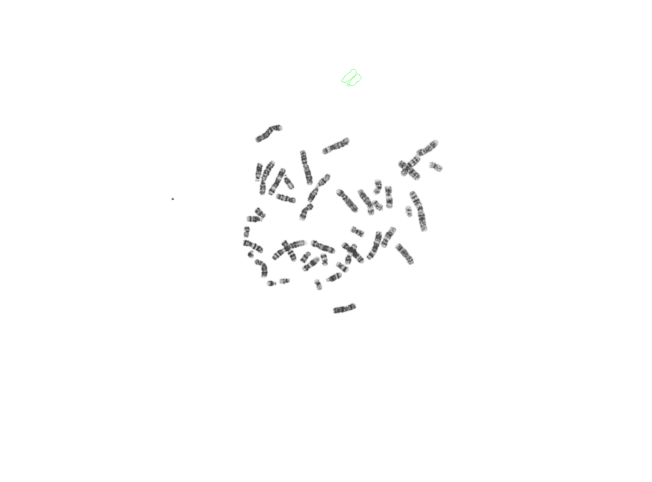

In [156]:
# 显示结果
plt.figure(figsize=(12, 6))
plt.imshow(metaphase_canvas)
plt.axis('off')
plt.show()

## 实验做完，开始绘制最终效果图

In [157]:
# 保存匹配的特征点加上报告图染色体轮廓罩回中期的最终结果图
save_dir_fp = r"./test/fm_cntr_hood_back_imgs"
# 获取当前时间
current_time = datetime.now()
# 格式化成字符串，例如：240703_153045
formatted_time = current_time.strftime("%y%m%d_%H%M%S")
save_dir_fp = os.path.join(save_dir_fp, formatted_time)
if not os.path.exists(save_dir_fp):
    os.makedirs(save_dir_fp)


# 画出匹配的染色体
for idx, matched_chromo in enumerate(matched_chromos):

    '''
        matched_chromos.append({
        "kyt_chromo": kyt_chromo,
        "sim_score": sim_score,
        "matched_chromo": matched_chromo,
        "flip_idx": flip_idx,
        "upsidedown": upsidedown,
        "flip_dict": flip_dict
    })

    target_chromo_flip_on_max = {
        "flip_idx": flip_idx,
        "similarity": similarity,
        "good_matches": good_matches,
        "query_kpts": query_kpts,
        "query_descs": query_descs,
        "target_kpts": target_kpts,
        "target_descs": target_descs,
    }
    '''

    kyt_chromo_bbox_bbg = matched_chromo["kyt_chromo"]["bbox_bbg"]
    metaphase_img = src_img
    kyt_chromo_kpts = matched_chromo["best_match_dict"]["query_kpts"]
    kyt_chromo_cntr = matched_chromo["kyt_chromo"]["cntr"]
    metaphase_chromo_kpts = matched_chromo["best_match_dict"]["target_kpts"]

    # 查看flip_idx，看是否需要对kyt_chromo_bbox_bbg进行翻转
    flip_idx = matched_chromo["flip_idx"]
    print(f"matched_idx: {idx}, flip_idx: {flip_idx}")
    flip_param = [None, 0, 1, -1]
    if flip_idx != 0:
        print(f"flip_idx != 0: {flip_idx} -> matched_idx: {idx}")
        kyt_chromo_bbox_bbg = cv2.flip(kyt_chromo_bbox_bbg, flip_param[flip_idx])
        gray_img = cv2.cvtColor(kyt_chromo_bbox_bbg, cv2.COLOR_BGR2GRAY) if len(kyt_chromo_bbox_bbg.shape) == 3 else kyt_chromo_bbox_bbg
        bin_img = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)[1]
        kyt_chromo_cntr = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]


    # 先绘制匹配的特征点
    feature_match_canvas = cv2.drawMatchesKnn(kyt_chromo_bbox_bbg, kyt_chromo_kpts, metaphase_img, metaphase_chromo_kpts, matched_chromo["best_match_dict"]["good_matches"], None, flags=2)

    # 再绘制报告图轮廓罩回后的轮廓
    # 提取匹配点坐标
    kyt_chromo_pts = np.float32([kyt_chromo_kps[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    metaphase_chromo_pts = np.float32([metaphase_chromo_kps[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # 计算仿射矩阵M
    M, mask = cv2.estimateAffinePartial2D(kyt_chromo_pts, metaphase_chromo_pts, method=cv2.RANSAC)

    # 变形轮廓
    transformed_contour = []
    for point in kyt_chromo_cntr:
        # 将点表示为齐次坐标
        point_homogeneous = np.array([point[0][0], point[0][1], 1]).reshape(3, 1)
        # 应用仿射变换
        transformed_point = np.dot(M, point_homogeneous)
        # 转换为普通坐标
        transformed_point = (int(transformed_point[0]), int(transformed_point[1]))
        transformed_contour.append(transformed_point)

    # 变形轮廓还要进行调整，drawMatchesKnn时，左边的图像是单根来自报告图的染色体，右边的图像是中期图
    # 所以，罩回中期图的轮廓坐标要整体加上左边图像的宽度
    for i in range(len(transformed_contour)):
        transformed_contour[i] = (transformed_contour[i][0] + kyt_chromo_bbox_bbg.shape[1], transformed_contour[i][1])

    # 在中期图上画出变形后的轮廓
    final_canvas = feature_match_canvas
    cv2.drawContours(final_canvas, [np.array(transformed_contour)], -1, (0, 255, 0), 1)

    # 获取kyt_chromo的染色体编号
    kyt_chromo_id = matched_chromo["kyt_chromo"]["chromo_id"]
    kyt_chromo_idx = matched_chromo["kyt_chromo"]["chromo_idx"]
    pos = matched_chromo["kyt_chromo"]["pos"]
    save_fn = f"FMCHB-{idx}_KYT-{kyt_chromo_id}-{pos}_FLIP-{kyt_flip_idx}.png"
    save_fp = os.path.join(save_dir_fp, save_fn)
    cv_imwrite(save_fp, feature_match_canvas)

matched_idx: 0, flip_idx: 3
flip_idx != 0: 3 -> matched_idx: 0
matched_idx: 1, flip_idx: 0
matched_idx: 2, flip_idx: 0
matched_idx: 3, flip_idx: 0
matched_idx: 4, flip_idx: 0
matched_idx: 5, flip_idx: 1
flip_idx != 0: 1 -> matched_idx: 5
matched_idx: 6, flip_idx: 3
flip_idx != 0: 3 -> matched_idx: 6
matched_idx: 7, flip_idx: 1
flip_idx != 0: 1 -> matched_idx: 7
matched_idx: 8, flip_idx: 3
flip_idx != 0: 3 -> matched_idx: 8
matched_idx: 9, flip_idx: 0
matched_idx: 10, flip_idx: 0
matched_idx: 11, flip_idx: 1
flip_idx != 0: 1 -> matched_idx: 11
matched_idx: 12, flip_idx: 0
matched_idx: 13, flip_idx: 0
matched_idx: 14, flip_idx: 3
flip_idx != 0: 3 -> matched_idx: 14
matched_idx: 15, flip_idx: 0
matched_idx: 16, flip_idx: 2
flip_idx != 0: 2 -> matched_idx: 16
matched_idx: 17, flip_idx: 0
matched_idx: 18, flip_idx: 0
matched_idx: 19, flip_idx: 3
flip_idx != 0: 3 -> matched_idx: 19
matched_idx: 20, flip_idx: 2
flip_idx != 0: 2 -> matched_idx: 20
matched_idx: 21, flip_idx: 3
flip_idx != 0: 3 

In [158]:
# 检测flip_idx是否正确
for matched_chromo in matched_chromos:
    print(matched_chromo["flip_idx"], matched_chromo["upsidedown"])

3 True
0 False
0 False
0 True
0 False
1 False
3 False
1 True
3 True
0 False
0 True
1 False
0 False
0 False
3 True
0 True
2 False
0 True
0 False
3 True
2 False
3 False
3 False
2 False
0 True
0 False
2 False
1 False
0 False
0 True
0 False
2 False
3 False
3 False
3 False
2 False
2 True
0 False
3 True
0 False
